# Import Data 

In [244]:
import warnings
import itertools
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import boxcox

from statsmodels.tsa.statespace.sarimax import SARIMAX
from matplotlib import rcParams
from statsmodels.tsa.seasonal import  STL
import scipy.stats as scs
import matplotlib.pyplot as plt
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

%matplotlib inline
rcParams['figure.figsize'] = 18, 5
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['lines.linewidth'] = 2.5

In [245]:
df = pd.read_csv('data/AusAntidiabeticDrug.csv')

df.head()

,ds,y
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


The dataset consists of 204 observations of monthly number of antidiabetic drug prescription in australia from 1991 to 2008

In [246]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ds      204 non-null    object 
 1   y       204 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.3+ KB


## Convert to time series

In [247]:
# rename columns if required
df.rename(columns={'y':'DrugPrescriptions', "ds": "Date"}, inplace=True)


In [248]:
# Explicitly specify the format of date
# Convert 'Date' to datetime, specifying the format
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')


In [249]:
df.head()

,Date,DrugPrescriptions
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


In [250]:

# Set the date as the index
df.set_index('Date', inplace=True)


# Display the dataframe
df.head()

,DrugPrescriptions
Date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


In [251]:
df.isna().sum()

DrugPrescriptions    0
dtype: int64

# Data Analysis And Visualization

<Axes: xlabel='Date'>

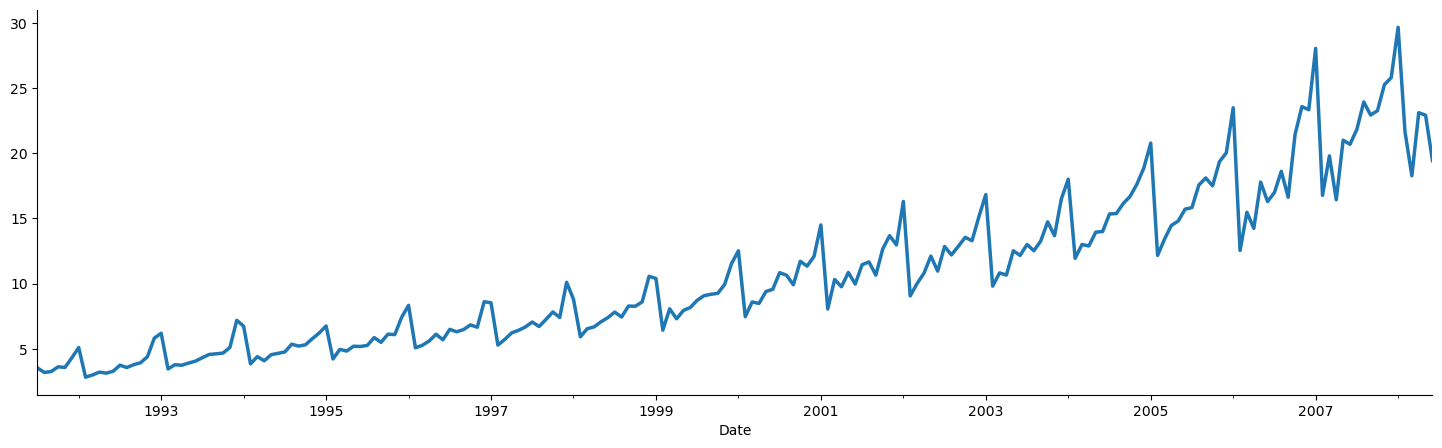

In [252]:
#plot time series
df['DrugPrescriptions'].plot()

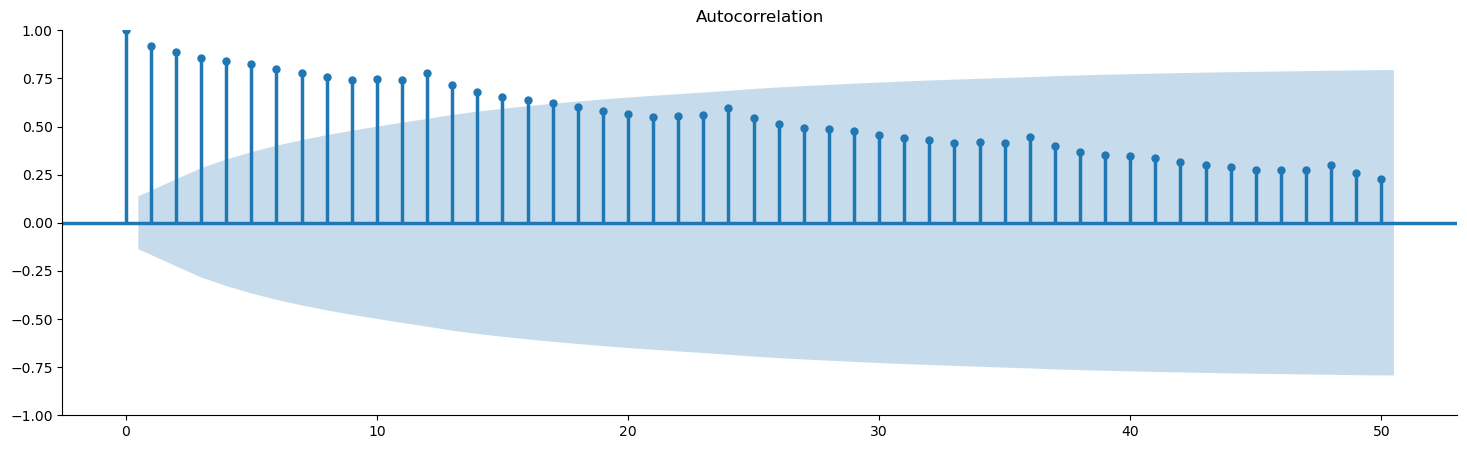

In [253]:
plot_acf(df.DrugPrescriptions,lags=50)
plt.show()

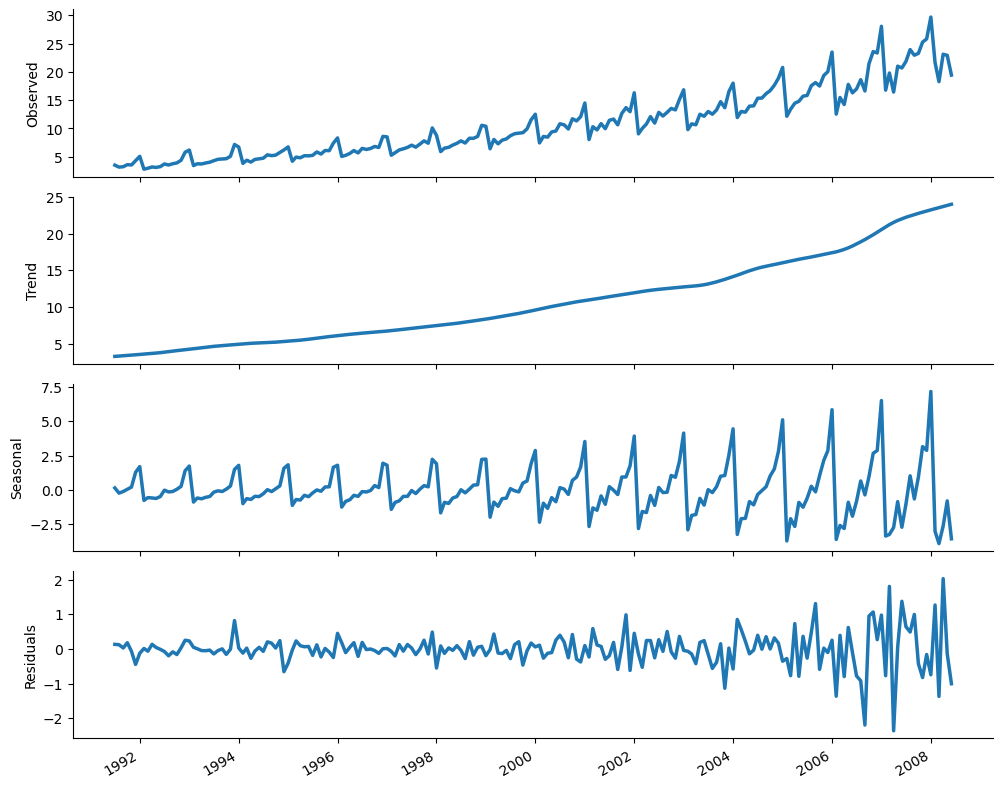

In [254]:
# decompose data to identify underlying structure
decomposition = STL(df.DrugPrescriptions, period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

# plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))

fig.autofmt_xdate()
plt.tight_layout()




# Check For Stationarity

## Rolling Statistics

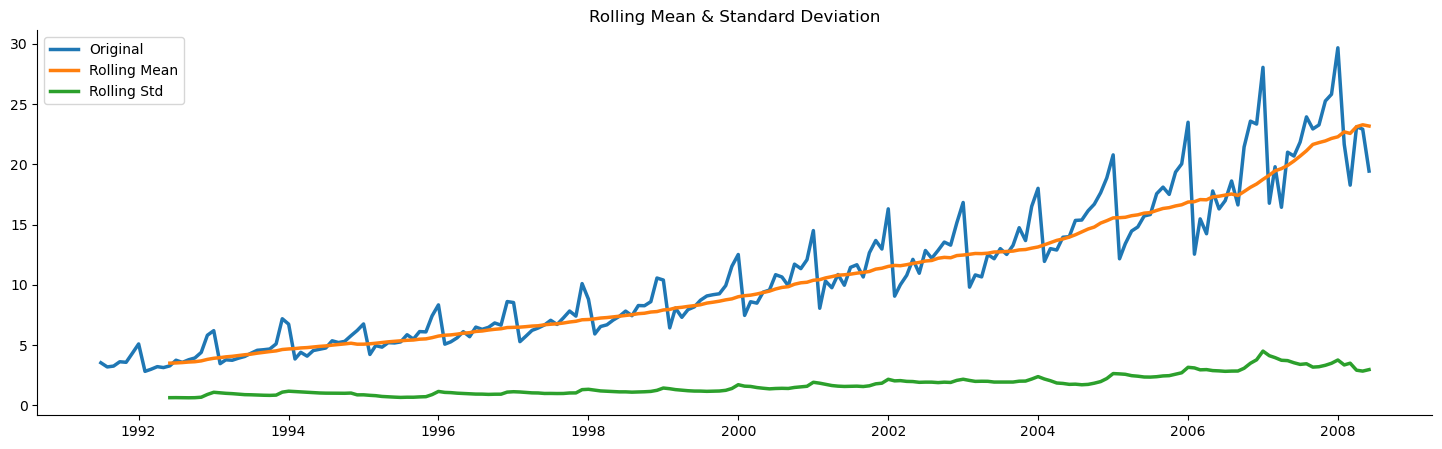

In [255]:
#Determing rolling statistics
rolmean = df.rolling(window=12).mean()
rolstd = df.rolling(window=12).std()

#Plot rolling statistics:
orig = plt.plot(df, label='Original')
mean = plt.plot(rolmean, label='Rolling Mean')
std = plt.plot(rolstd, label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

 The variation in standard deviation is small, mean is clearly increasing with time and this is not a stationary series

## ADF Test

In [256]:
# ADF Test
def adf_test(series, alpha=0.05):
    """
    Performs the Augmented Dickey-Fuller (ADF) test on a time series.

    Parameters:
    - series (pd.Series): The time series data to test.
    - alpha (float): Significance level (default is 0.05).

    Returns:
    - None (prints the results)
    """
    result = adfuller(series, autolag='AIC')

    # Create results dictionary
    output = {
        'Test Statistic': result[0],
        'p-value': result[1],
        '# Lags Used': result[2],
        'Number of Observations': result[3],
    }

    # Add critical values
    for key, value in result[4].items():
        output[f'Critical Value ({key})'] = value

    # Convert to DataFrame for better readability
    output_df = pd.DataFrame(output.items(), columns=['Metric', 'Value'])

    # Print the results
    print("\n🔍 Results of Augmented Dickey-Fuller Test:")
    print(output_df.to_string(index=False))

    # Interpretation
    print("\n📌 Interpretation:")
    if result[1] <= alpha:
        print(f"✅ The time series is **stationary** (p-value = {result[1]:.5f} ≤ {alpha})")
    else:
        print(f"❌ The time series is **not stationary** (p-value = {result[1]:.5f} > {alpha})")


In [257]:
adf_test(df['DrugPrescriptions'])


🔍 Results of Augmented Dickey-Fuller Test:
                Metric      Value
        Test Statistic   3.145186
               p-value   1.000000
           # Lags Used  15.000000
Number of Observations 188.000000
   Critical Value (1%)  -3.465620
   Critical Value (5%)  -2.877040
  Critical Value (10%)  -2.575032

📌 Interpretation:
❌ The time series is **not stationary** (p-value = 1.00000 > 0.05)


# Elimination of Stationarity 

## Elimination of non-constant variance (Heteroscedasticity)

In [258]:
def apply_boxcox(series, plot=True):

    # Apply Box-Cox transformation
    transformed_data, lambda_value = boxcox(series)

    # Convert to pandas Series
    transformed_series = pd.Series(transformed_data, index=series.index)

  
    return transformed_series, lambda_value


In [259]:
# Apply Box-Cox transformation
df_boxcox, lambda_value = apply_boxcox(df['DrugPrescriptions'])

# Print the optimal lambda value
print(f"Optimal λ (lambda): {lambda_value:.4f}")

Optimal λ (lambda): 0.0615


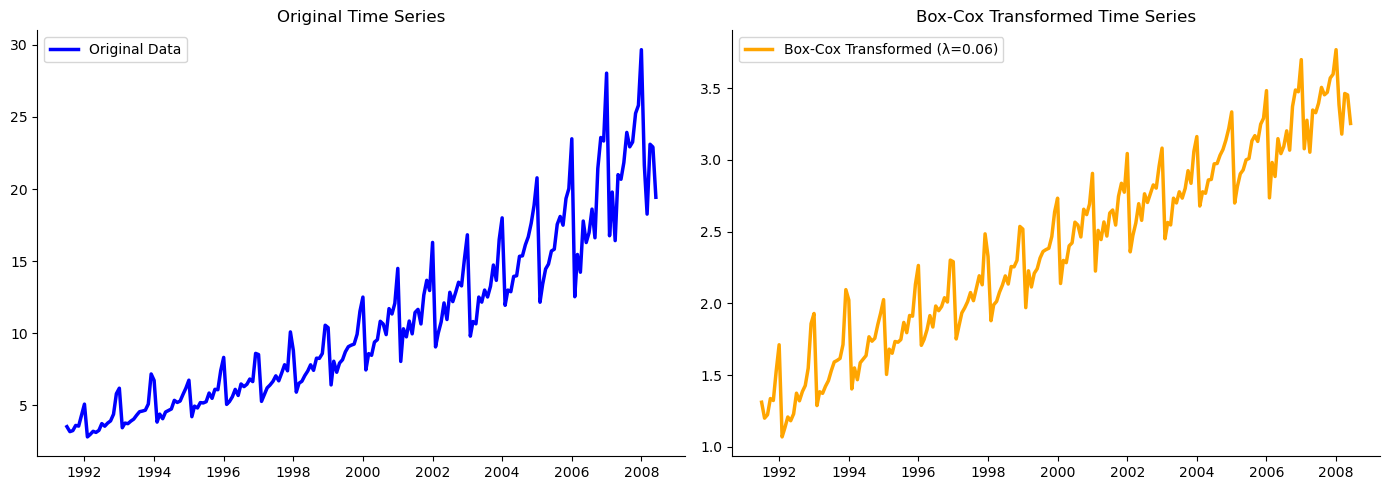

In [260]:
# plot before and after series
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original series
axes[0].plot(df, label='Original Data', color='blue')
axes[0].set_title('Original Time Series')
axes[0].legend()

# Box-Cox transformed series
axes[1].plot(df_boxcox, label=f'Box-Cox Transformed (λ={lambda_value:.2f})', color='orange')
axes[1].set_title('Box-Cox Transformed Time Series')
axes[1].legend()

plt.tight_layout()
plt.show()

## Check for Stationarity of Box Cox Transformed Series


In [261]:
adf_test(df_boxcox)


🔍 Results of Augmented Dickey-Fuller Test:
                Metric      Value
        Test Statistic  -0.581157
               p-value   0.875183
           # Lags Used  14.000000
Number of Observations 189.000000
   Critical Value (1%)  -3.465431
   Critical Value (5%)  -2.876957
  Critical Value (10%)  -2.574988

📌 Interpretation:
❌ The time series is **not stationary** (p-value = 0.87518 > 0.05)


In [262]:
# first  order differencing

# Apply differencing to the Box-Cox transformed data (12 periods lag)
# df_diff_1 = pd.Series(df_boxcox - df_boxcox.shift(periods=12), index=df.index)
df_diff_1 = np.diff(df_boxcox, n=1)

ad_fuller_result = adfuller(df_diff_1)




In [263]:
#check with ADF test
adf_test(df_diff_1)


🔍 Results of Augmented Dickey-Fuller Test:
                Metric      Value
        Test Statistic  -3.836085
               p-value   0.002559
           # Lags Used  15.000000
Number of Observations 187.000000
   Critical Value (1%)  -3.465812
   Critical Value (5%)  -2.877123
  Critical Value (10%)  -2.575077

📌 Interpretation:
✅ The time series is **stationary** (p-value = 0.00256 ≤ 0.05)


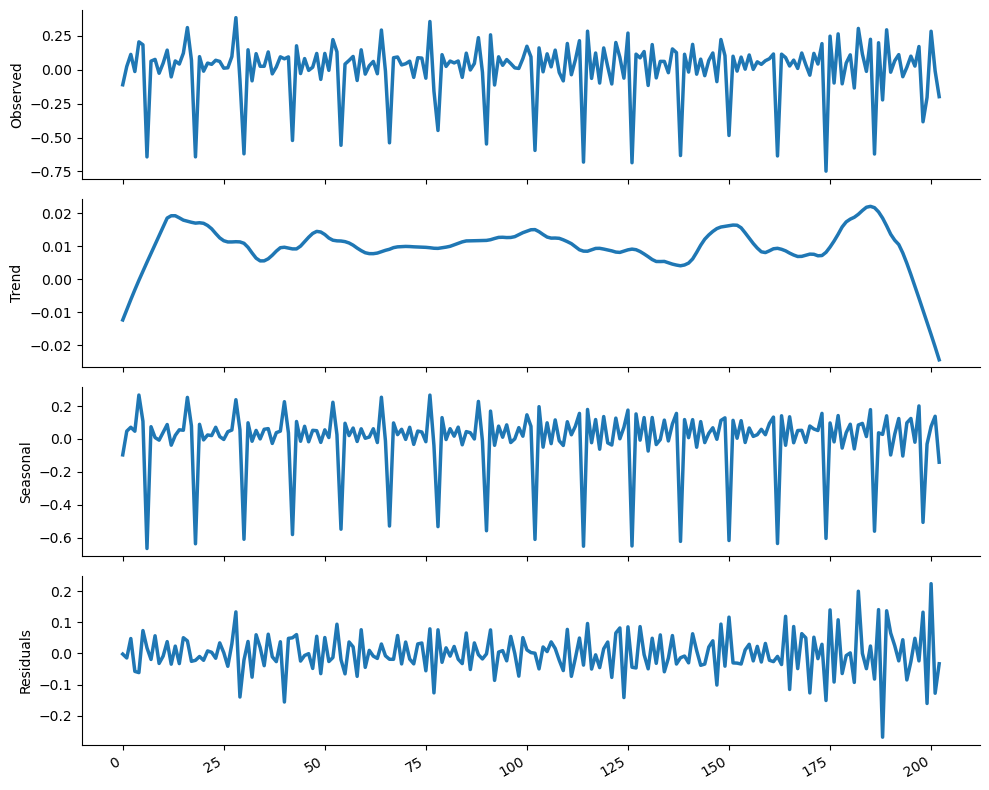

In [264]:
# decompose data to identify underlying structure after removing seasonality
decomposition = STL(df_diff_1, period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

# plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))

fig.autofmt_xdate()
plt.tight_layout()




In [265]:
df_seasonal_diff = np.diff(df_diff_1, n=12)

#check with ADF test
adf_test(df_seasonal_diff)


🔍 Results of Augmented Dickey-Fuller Test:
                Metric      Value
        Test Statistic -19.777814
               p-value   0.000000
           # Lags Used  15.000000
Number of Observations 175.000000
   Critical Value (1%)  -3.468280
   Critical Value (5%)  -2.878202
  Critical Value (10%)  -2.575653

📌 Interpretation:
✅ The time series is **stationary** (p-value = 0.00000 ≤ 0.05)


# Train Test Split Data

In [266]:
num_train = 180

# Split the original data into training and testing sets
train = df[:num_train] 
test = df[num_train:]  

In [267]:
train.head()

,DrugPrescriptions
Date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


In [268]:
test.tail()

,DrugPrescriptions
Date,
2008-02-01,21.654285
2008-03-01,18.264945
2008-04-01,23.107677
2008-05-01,22.912510
2008-06-01,19.431740


In [269]:
# Split the transformed Box-Cox and differenced data into training and testing sets
train_data = df_seasonal_diff[:num_train]  
test_data = df_seasonal_diff[num_train:] 
     

## Best Order Selection

In [270]:
from itertools import product
import pandas as pd

# Define the parameter ranges
p_range = range(0, 3, 1)
q_range = range(0, 3, 1)
P_range = range(0, 3, 1)
Q_range = range(0, 3, 1)

# Differencing values
d = 1  # Non-seasonal differencing
D = 1  # seasonal differencing
s = 12  # 12 for monthly data with yearly seasonality)

# # Generate ARIMA order combinations
# ARIMA_order_list = list(product(p_range, q_range, P_range, Q_range))
# print(ARIMA_order_list)

In [271]:
# # Call the optimize_SARIMA function
# ARIMA_result_df = optimize_SARIMA(train, ARIMA_order_list, d, D, s)

# # Display results
# ARIMA_result_df

## pmdarima Method

In [272]:
model = auto_arima(
    train,
    d=d,
    D=D,
    seasonal=True,
    m=s,  # Periodicity of the seasonality (e.g., 12 for monthly data)
    p=p_range,  # List of possible p values
    q=q_range,  # List of possible q values
    P=P_range,  # List of possible P values
    Q=Q_range,  # List of possible Q values
    stepwise=True,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    boxcox=True  # Enable Box-Cox transformation
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=323.528, Time=1.70 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=432.513, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=347.353, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=328.418, Time=0.29 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=322.785, Time=1.25 sec
 ARIMA(2,1,2)(0,1,0)[12]             : AIC=325.068, Time=0.53 sec
 ARIMA(2,1,2)(0,1,2)[12]             : AIC=321.114, Time=3.14 sec
 ARIMA(2,1,2)(1,1,2)[12]             : AIC=321.608, Time=5.31 sec
 ARIMA(1,1,2)(0,1,2)[12]             : AIC=323.615, Time=2.10 sec
 ARIMA(2,1,1)(0,1,2)[12]             : AIC=320.357, Time=2.15 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=322.405, Time=0.67 sec
 ARIMA(2,1,1)(1,1,2)[12]             : AIC=321.224, Time=3.36 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=322.862, Time=1.20 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=323.093, Time=1.49 sec
 ARIMA(2,1,0)(0,1,2)[12]         

In [273]:
# from pmdarima import auto_arima

# # # Fit the SARIMA model using pmdarima's auto_arima function with limited search space
# model = auto_arima(
#     train,
#     d=d,
#     D=D,
#     seasonal=True,
#     m=s,  # Periodicity of the seasonality (e.g., 12 for monthly data with yearly seasonality)
#     p=p_range,  # List of possible p values
#     q=q_range,  # List of possible q values
#     P=P_range,  # List of possible P values
#     Q=Q_range,  # List of possible Q values
#     stepwise=True,  # Stepwise optimization for hyperparameter selection
#     trace=True,  # Print progress during the optimization process
#     error_action='ignore',  # Ignore any errors during model fitting
#     suppress_warnings=True  # Suppress warnings
# )

# # Get the best model and its parameters
# best_order = model.order  # (p, d, q)
# best_seasonal_order = model.seasonal_order  # (P, D, Q, s)
# best_aic = model.aic()

# # Create a DataFrame to display the results
# result_df = pd.DataFrame({
#     '(p, q, P, Q)': [best_order + best_seasonal_order[:3]],
#     'AIC': [best_aic]
# })

# result_df


In [274]:

model = SARIMAX(
                train_data, 
                order=(2,1, 1),
                seasonal_order=(0,1,2,12)
            ).fit(disp=False)


In [275]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  180
Model:             SARIMAX(2, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood                -853.151
Date:                                 Fri, 07 Mar 2025   AIC                           1718.302
Time:                                         17:44:44   BIC                           1737.010
Sample:                                              0   HQIC                          1725.895
                                                 - 180                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7177      0.039    -43.888      0.000      -1.794      -1.641
ar.L2         -0.8823      0.041    -21.395      0.000      -0.963      -0.802
ma.L1         -0.9976      1.707     -0.585      0.559      -4.342       2.347
ma.S.L12      -0.4143      0.094     -4.429      0.000      -0.598      -0.231
ma.S.L24      -0.3283      0.115     -2.858      0.004      -0.553      -0.103
sigma2      1406.5279   2411.119      0.583      0.560   -3319.178    6132.234
===================================================================================
Ljung-Box (L1) (Q):                  83.16   Jarque-Bera (JB):                 0.24
Prob(Q):                              0.00   Prob(JB):                         0.89
Heteroskedasticity (H):               0.98   Skew:                             0.02
Prob(H) (two-sided):                  0.93   Kurtosis:                         3.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

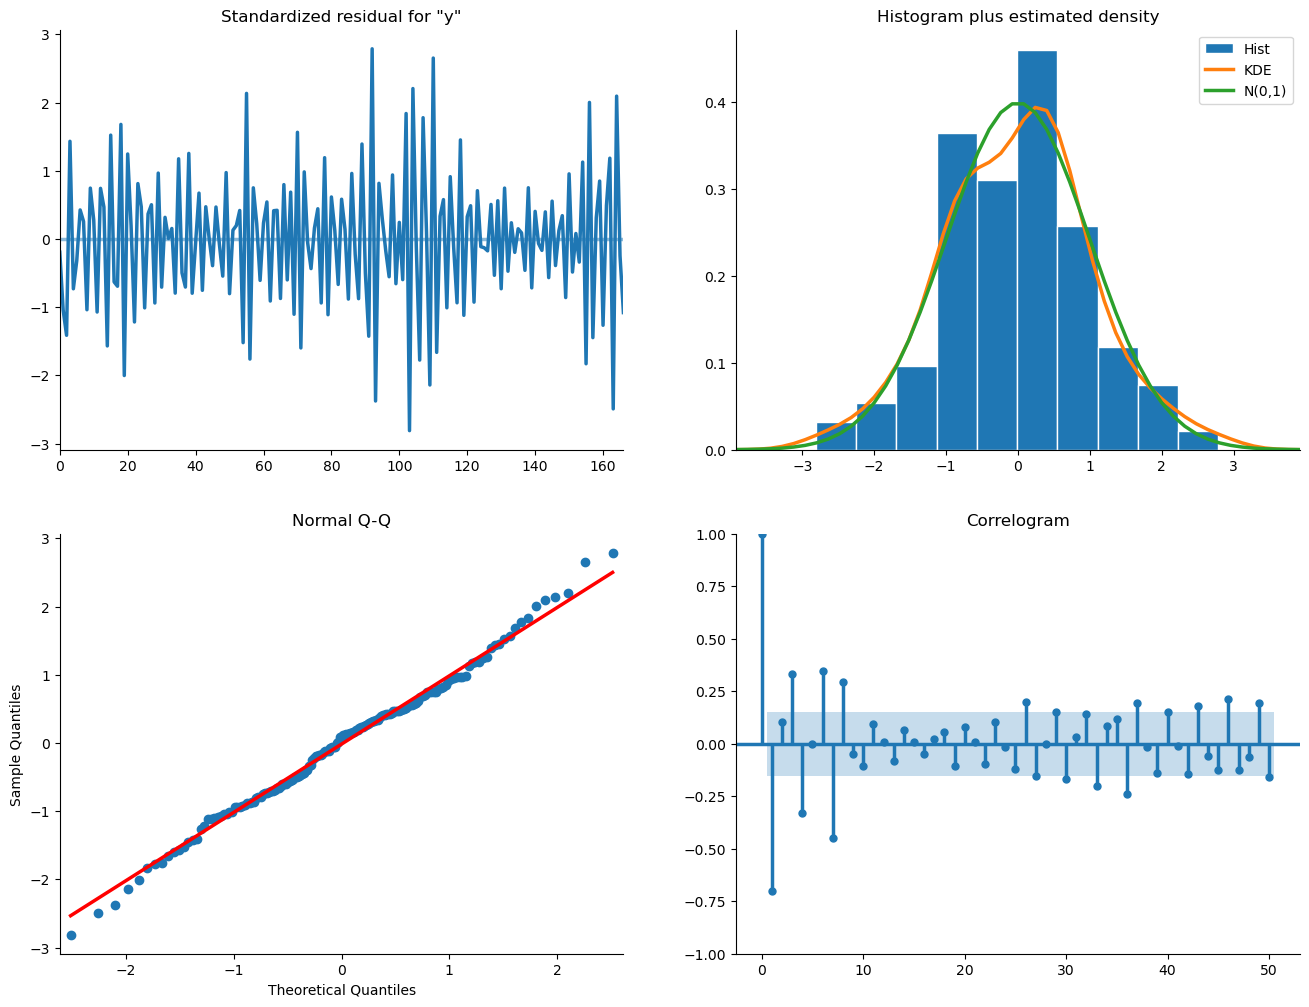

In [276]:
model.plot_diagnostics(lags=50, figsize=(16,12))
plt.show()

In [277]:
df_boxcox


Date
1991-07-01    1.310468
1991-08-01    1.199335
1991-09-01    1.223164
1991-10-01    1.336047
1991-11-01    1.322441
                ...   
2008-02-01    3.385266
2008-03-01    3.180677
2008-04-01    3.463910
2008-05-01    3.453624
2008-06-01    3.254856
Length: 204, dtype: float64

In [278]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len

    if method == 'last_season':
        pred_last_season = []
        
        for i in range(train_len, total_len, window):
            last_season = df['DrugPrescriptions'][i-window:i].values
            pred_last_season.extend(last_season)
            
        return pred_last_season
    
    elif method == 'SARIMA':
        pred_SARIMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(2,1,3), seasonal_order=(1,1,3,12), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMA.extend(oos_pred)
            
        return pred_SARIMA

In [279]:
pred_df = df[168:]

pred_df

,DrugPrescriptions
Date,
2005-07-01,15.829550
2005-08-01,17.554701
2005-09-01,18.100864
2005-10-01,17.496668
2005-11-01,19.347265
2005-12-01,20.031291
2006-01-01,23.486694
2006-02-01,12.536987
2006-03-01,15.467018


In [280]:
TRAIN_LEN = 168
HORIZON = 36
WINDOW = 12

pred_df['last_season'] = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last_season')

pred_df

,DrugPrescriptions,last_season
Date,,
2005-07-01,15.829550,15.339097
2005-08-01,17.554701,15.370764
2005-09-01,18.100864,16.142005
2005-10-01,17.496668,16.685754
2005-11-01,19.347265,17.636728
2005-12-01,20.031291,18.869325
2006-01-01,23.486694,20.778723
2006-02-01,12.536987,12.154552
2006-03-01,15.467018,13.402392


In [281]:
pred_df['SARIMA_boxcox'] = rolling_forecast(df_boxcox, TRAIN_LEN, HORIZON, WINDOW, 'SARIMA')

pred_df

,DrugPrescriptions,last_season,SARIMA_boxcox
Date,,,
2005-07-01,15.829550,15.339097,3.082859
2005-08-01,17.554701,15.370764,3.079903
2005-09-01,18.100864,16.142005,3.111324
2005-10-01,17.496668,16.685754,3.174996
2005-11-01,19.347265,17.636728,3.218556
2005-12-01,20.031291,18.869325,3.348374
2006-01-01,23.486694,20.778723,3.454013
2006-02-01,12.536987,12.154552,2.837345
2006-03-01,15.467018,13.402392,2.966598


## Inverse Transform Data

In [282]:
# Function to perform inverse Box-Cox transformation
def inverse_boxcox(y, lam):
    return np.power(y * lam + 1, 1 / lam) if lam != 0 else np.exp(y)

In [283]:
pred_df['SARIMA']=inverse_boxcox(pred_df['SARIMA_boxcox'],lambda_value)
pred_df

,DrugPrescriptions,last_season,SARIMA_boxcox,SARIMA
Date,,,,
2005-07-01,15.829550,15.339097,3.082859,16.826651
2005-08-01,17.554701,15.370764,3.079903,16.784893
2005-09-01,18.100864,16.142005,3.111324,17.233838
2005-10-01,17.496668,16.685754,3.174996,18.178357
2005-11-01,19.347265,17.636728,3.218556,18.852295
2005-12-01,20.031291,18.869325,3.348374,21.002485
2006-01-01,23.486694,20.778723,3.454013,22.919872
2006-02-01,12.536987,12.154552,2.837345,13.670796
2006-03-01,15.467018,13.402392,2.966598,15.255494


In [284]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [285]:
mape_naive_seasonal = mape(pred_df.DrugPrescriptions, pred_df.last_season)
mape_SARIMA = mape(pred_df.DrugPrescriptions, pred_df.SARIMA)

print(mape_naive_seasonal, mape_SARIMA)

12.686561923100614 7.62776797368419


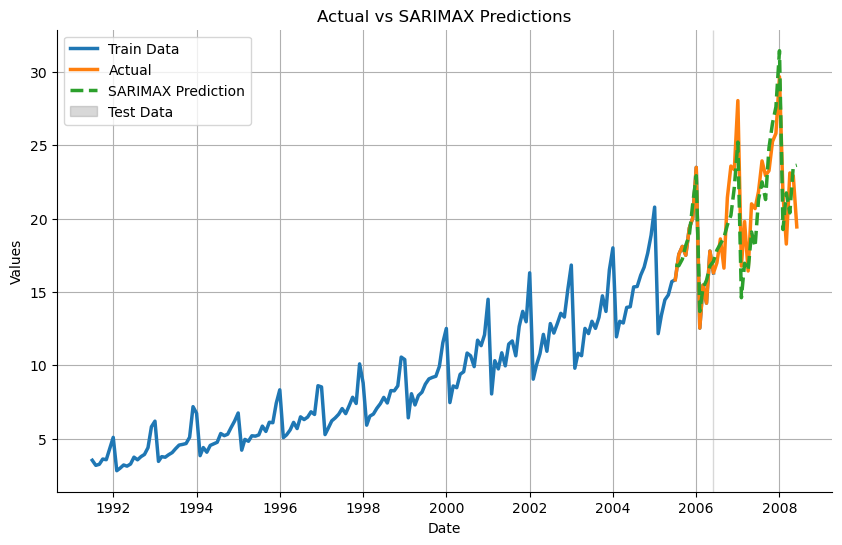

In [286]:
# Plotting actual vs SARIMAX predictions
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Train Data')

plt.plot(pred_df.index, pred_df['DrugPrescriptions'], label='Actual', linestyle='-')
plt.plot(pred_df.index, pred_df['SARIMA'], label='SARIMAX Prediction', linestyle='--')
plt.axvspan(train.index[-1], train.index[-1], color='gray', alpha=0.3, label='Test Data')

plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Actual vs SARIMAX Predictions')
plt.legend()
plt.grid(True)
plt.show()